### **Free Energy Terms for Ternary A-B-C Phase-Field Model**

$ \textbf{Phase-field energy    } ( f_{\phi} ( \phi ) )$
$$
f_\phi(\phi) = 
\begin{cases}
+\infty & \text{if } \phi < 0 \\
\lambda_\phi \phi (1 - \phi) + \frac{\sigma_\phi}{2} \left( \left( \frac{\partial \phi}{\partial x} \right)^2 + \left( \frac{\partial \phi}{\partial y} \right)^2 \right) & \text{for } 0 \leq \phi \leq 1 \\
+\infty & \text{if } \phi > 1
\end{cases}
$$

$\textbf{Thermodynamic energy    } ( f_c(\phi, \{c_i\}, T) )$
$$
\begin{aligned}
f_c(\phi, \{c_i\}, T) &= \sum_{i=A,B,C} \left[ \phi c_i L_i \left( \frac{T - T_i}{T_i} \right) + \frac{k_B T}{V_a} c_i \log c_i \right] + \Omega c_A c_C \\
\text{where} \quad c_C &= 1 - c_A - c_B
\end{aligned}
$$

$\textbf{Gradient energy    } ( f_g(c_A, c_B) )$
$$
f_g(c_A, c_B) = \frac{\sigma_A}{2} |\nabla c_A|^2 + \frac{\sigma_B}{2} |\nabla c_B|^2 + \frac{\sigma_C}{2} |\nabla c_C|^2
$$

$$
|\nabla c_i|^2 = \left( \frac{\partial c_i}{\partial x} \right)^2 + \left( \frac{\partial c_i}{\partial y} \right)^2
$$

$\textbf{ Total free energy density  } f $
$$
f(c_A, c_B, \phi, T) = f_\phi(\phi) + f_c(\phi, \{c_i\}, T) + f_g(c_A, c_B)
$$


In [1]:
import numpy as np
global lambda_phi,sigma_phi,L_A,L_B,L_C,sigma_A,sigma_B,sigma_C,T_A,T_B,T_C,Omega,k_B,V_a,D_l 

L_A,L_B,L_C= 17.6,11.8,11.5  # Latent heats of fusion in eV
lambda_phi=1.59    # Phase field mobility coefficient in eV
T_A,T_B,T_C= 3290,1941,1358  # Melting temperatures in eV
sigma_A,sigma_B,sigma_C= 9.0,9.0,9.0 # Gradient coefficients for concentrations in eV
sigma_phi=3.18  # Gradient coefficient for phase field in eV
Omega=90  # Interaction energy in eV
V_a= 0.01  # Atomic volume in eV
k_B= 8.617e-5  # Boltzmann constant in eV/K
D_l=7e9
def f_phi(phi):
    return lambda_phi*phi*(1-phi)+ sigma_phi/2 * (np.gradient(phi, dx, axis=0)**2)

def f_c(phi, c_A, c_B, T):
    c_C = 1.0 - c_A - c_B

    # Avoid log(0) and log(negative) by clamping concentrations
    c_A = np.clip(c_A, 1e-12, 1.0)
    c_B = np.clip(c_B, 1e-12, 1.0)
    c_C = np.clip(c_C, 1e-12, 1.0)

    term_A = phi * c_A * L_A * (T - T_A) / T_A + (k_B * T / V_a) * c_A * np.log(c_A)
    term_B = phi * c_B * L_B * (T - T_B) / T_B + (k_B * T / V_a) * c_B * np.log(c_B)
    term_C = phi * c_C * L_C * (T - T_C) / T_C + (k_B * T / V_a) * c_C * np.log(c_C)
    interaction = Omega * c_A * c_C
    return term_A + term_B + term_C + interaction


def f_g(c_A,c_B):
    c_C=1.0 - c_A - c_B
    dca_dx = np.gradient(c_A, dx)
    dcb_dx = np.gradient(c_B, dx)
    dcc_dx = np.gradient(c_C, dx)
    return (sigma_A/2 * (dca_dx**2) +sigma_B/2 * (dcb_dx**2) +sigma_C/2 * (dcc_dx**2))

def f(c_A, c_B, phi, T):
    return f_phi(phi) + f_c(phi, c_A, c_B, T) + f_g(c_A,c_B)

$$
$$

### **Concentration terms**

$$
\frac{\partial c_i}{\partial t} = \nabla \cdot \left( \sum_j M_{ij} \nabla \mu_j \right)
$$
$$
\frac{\partial c_A}{\partial t} = \nabla \cdot \left( M_{AA} \nabla \mu_A + M_{AB} \nabla \mu_B \right)
$$
$$
\frac{\partial c_B}{\partial t} = \nabla \cdot \left( M_{BA} \nabla \mu_A + M_{BB} \nabla \mu_B \right)
$$

In [2]:
def dc_dt(M, dmuA_dx, dmuB_dx,dx):
    M_AA = M[0, 0]
    M_AB = M[0, 1]
    M_BA = M[1, 0]
    M_BB = M[1, 1]     
    # Fluxes for species A
    JAx = M_AA * dmuA_dx + M_AB * dmuB_dx
    #JAy = M_AA * dmuA_dy + M_AB * dmuB_dy

    # Fluxes for species B
    JBx = M_BA * dmuA_dx + M_BB * dmuB_dx
    #JBy = M_BA * dmuA_dy + M_BB * dmuB_dy

    # Divergence of fluxes (central differences using np.roll for periodic BCs)
    divJA = (np.roll(JAx, -1) - np.roll(JAx, 1)) / (2 * dx)
            #(np.roll(JAy, -1, axis=0) - np.roll(JAy, 1, axis=0)) / (2 * dy)

    divJB = (np.roll(JBx, -1) - np.roll(JBx, 1)) / (2 * dx) 
            #np.roll(JBy, -1, axis=0) - np.roll(JBy, 1, axis=0)) / (2 * dy)

    dcA_dt = divJA
    dcB_dt = divJB

    return dcA_dt, dcB_dt

$ \textbf{Functional Derivative of the Free Energy} ( \mathcal{F} ) w.r.t. ( \phi ) $

$$
\frac{\delta \mathcal{F}}{\delta \phi} =
\frac{\partial f_\phi}{\partial \phi} +
\frac{\partial f_c}{\partial \phi} -
\nabla \cdot \left( \frac{\partial f_\phi}{\partial (\nabla \phi)} \right)
$$

With the definitions:

$$
f_\phi(\phi) = \lambda_\phi \phi (1 - \phi) + \frac{\sigma_\phi}{2} |\nabla \phi|^2
$$

$$
\frac{\partial f_\phi}{\partial \phi} = \lambda_\phi (1 - 2\phi), \quad
\frac{\partial f_\phi}{\partial (\nabla \phi)} = \sigma_\phi \nabla \phi
\Rightarrow
\nabla \cdot \left( \frac{\partial f_\phi}{\partial (\nabla \phi)} \right) = \sigma_\phi \nabla^2 \phi
$$

And from the thermodynamic free energy:

$$
\frac{\partial f_c}{\partial \phi} = \sum_{i=A,B,C} c_i L_i \left( \frac{T - T_i}{T_i} \right)
$$

So the full expression becomes:

$$
\frac{\delta \mathcal{F}}{\delta \phi} =
\lambda_\phi (1 - 2\phi) +
\sum_{i=A,B,C} c_i L_i \left( \frac{T - T_i}{T_i} \right)
- \sigma_\phi \nabla^2 \phi
$$

In [3]:
def dF_dphi(phi, cA, cB, T):
    cC = 1.0 - cA - cB

    # --- ∂f_phi/∂phi ---
    df_phi_dphi = lambda_phi * (1 - 2 * phi)

    # --- ∂f_c/∂phi ---
    df_c_dphi = (
        cA * L_A * (T - T_A) / T_A +
        cB * L_B * (T - T_B) / T_B +
        cC * L_C * (T - T_C) / T_C
    )

    # --- ∇²phi (Laplacian) ---
    d2phi_dx2 = (np.roll(phi, -1) - 2 * phi + np.roll(phi, 1)) / dx**2
    #d2phi_dy2 = (np.roll(phi, -1, axis=0) - 2 * phi + np.roll(phi, 1, axis=0)) / dy**2
    laplacian_phi = d2phi_dx2  # + d2phi_dy

    # --- δF/δphi ---
    deltaF_delta_phi = df_phi_dphi + df_c_dphi - sigma_phi * laplacian_phi

    return deltaF_delta_phi

In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Constants (make sure these are defined in your script)
eps = 1e-10  # Small epsilon to prevent log/div-zero

def Mobility(phi, c_A, c_B, T):
    # Clip to avoid instability at boundaries
    c_A = np.clip(c_A, eps, 1 - eps)
    c_B = np.clip(c_B, eps, 1 - eps)

    M_l = V_a * D_l / (k_B * T)
    M_o = M_l * (1 - phi)
    
    M = M_o * np.array([
        [c_A * (1 - c_A), -c_A * c_B],
        [-c_B * c_A, c_B * (1 - c_B)]
    ])
    return M

def mu_A(phi, c_A, c_C, T):
    # Smooth concentrations before Laplacian
    c_A_s = gaussian_filter1d(c_A, sigma=1)
    c_C_s = gaussian_filter1d(c_C, sigma=1)

    # Clip for log stability
    c_A_s = np.clip(c_A_s, eps, 1 - eps)
    c_C_s = np.clip(c_C_s, eps, 1 - eps)

    mu_1 = phi * L_A * (T - T_A) / T_A + (k_B * T / V_a) * (np.log(c_A_s) + 1) + Omega * c_C_s

    d2cA_dx2 = (np.roll(c_A_s, -1) - 2 * c_A_s + np.roll(c_A_s, 1)) / dx**2
    d2cC_dx2 = (np.roll(c_C_s, -1) - 2 * c_C_s + np.roll(c_C_s, 1)) / dx**2

    mu_2 = - sigma_A * (d2cA_dx2 - d2cC_dx2)
    return mu_1 + mu_2

def mu_B(phi, c_B, c_C, T):
    c_B_s = gaussian_filter1d(c_B, sigma=1)
    c_C_s = gaussian_filter1d(c_C, sigma=1)

    c_B_s = np.clip(c_B_s, eps, 1 - eps)
    c_C_s = np.clip(c_C_s, eps, 1 - eps)

    mu_1 = phi * L_B * (T - T_B) / T_B + (k_B * T / V_a) * (np.log(c_B_s) + 1)

    d2cB_dx2 = (np.roll(c_B_s, -1) - 2 * c_B_s + np.roll(c_B_s, 1)) / dx**2
    d2cC_dx2 = (np.roll(c_C_s, -1) - 2 * c_C_s + np.roll(c_C_s, 1)) / dx**2

    mu_2 = - sigma_B * (d2cB_dx2 - d2cC_dx2)
    return mu_1 + mu_2

def mu_C(phi, c_C, c_A, T):
    c_C_s = gaussian_filter1d(c_C, sigma=1)
    c_A_s = gaussian_filter1d(c_A, sigma=1)

    c_C_s = np.clip(c_C_s, eps, 1 - eps)
    c_A_s = np.clip(c_A_s, eps, 1 - eps)

    mu_1 = phi * L_C * (T - T_C) / T_C + (k_B * T / V_a) * (np.log(c_C_s) + 1) + Omega * c_A_s

    d2cC_dx2 = (np.roll(c_C_s, -1) - 2 * c_C_s + np.roll(c_C_s, 1)) / dx**2
    mu_2 = - sigma_C * d2cC_dx2
    return mu_1 + mu_2

def dmu_dx(ca, cb, dc1_dx, dc2_dx, T):
    ca = np.clip(ca, eps, 1 - eps)
    cb = np.clip(cb, eps, 1 - eps)
    cc = np.clip(1 - ca - cb, eps, 1 - eps)

    pre_factor = (k_B * T) / V_a

    dmua_dx = pre_factor * (dc1_dx / ca + (dc1_dx + dc2_dx) / cc) - Omega * (2 * dc1_dx + dc2_dx)
    dmub_dx = pre_factor * (dc2_dx / cb + (dc1_dx + dc2_dx) / cc) - Omega * dc1_dx

    return dmua_dx, dmub_dx

In [5]:
steps=200000
## Inialization of phi and concnertarion
Nx, Ny = 500, 150
dx = 0.1
dt = 1e-13
phi = np.ones(Nx)
cA = 0.4 * np.ones(Nx)
cB = 0.6 * np.ones(Nx)
cC = 1.0 - cA - cB
L_phi=1.14e9
T=1775
sigma_phi=3.18
# Add small perturbation
random_noise=0.025 * (2 * np.random.rand(Nx) - 1)
phi += 0.01 * (2 * np.random.rand(Nx) - 1)
cA +=  random_noise
cB -=  random_noise
cC = 1.0 - cA - cB

n_liquid_rows = 150  # top 16 rows (~3.2 μm for dx=0.25)
phi[:n_liquid_rows] = 0
cA[:n_liquid_rows] = 1e-6
cB[:n_liquid_rows] = 1e-6

phi[Nx-n_liquid_rows:] = 0
cA[Nx-n_liquid_rows:]=1e-6
cB[Nx-n_liquid_rows:]=1e-6
cC = 1.0 - cA - cB
phi_values = [phi]
conc_A=[cA.copy()]
conc_B=[cB.copy()]
conc_c=[cC.copy()]
    #phi_values.append(phi.copy())
    #conc_A.append(np.array(cA.copy()))
    #conc_B.append(np.array(cB.copy()))
    #conc_C.append(np.array(cC.copy()))
def periodic_gradient(f, dx):
    return (np.roll(f, -1) - np.roll(f, 1)) / (2 * dx)
def enforce_periodic(arr):
    arr[0] = arr[-2]
    arr[-1] = arr[1]
    return arr


for step in range(steps):
    # Update chemical potentials
    muA = mu_A(phi, cA, cC, T)
    muB= mu_B(phi, cB,cC, T)
    # dcA_dx=periodic_gradient(cA, dx)
    # dcB_dx=periodic_gradient(cB, dx)
    # Compute gradients
    # dmu_A_dx,dmu_B_dx=dmu_dx(cA, cB, dcA_dx, dcB_dx, T)
    cC=1.0 - cA - cB
    cC=np.clip(cC, 1e-6, 1.0)
    dmu_A_dx = periodic_gradient(mu_A(phi,cA,cC,T), dx)
    dmu_B_dx = periodic_gradient(mu_B(phi,cB,cC,T), dx)

    # Compute mobility terms
    M=Mobility(phi,cA,cB,T)

    # Compute dc/dt
    dcA_dt,dcB_dt=dc_dt(M, dmu_A_dx, dmu_B_dx,dx)

    # Update concentrations
    cA += dt * dcA_dt
    cB += dt * dcB_dt
    cA = np.clip(cA, 1e-6, 1.0)
    cB = np.clip(cB, 1e-6, 1.0)
    cC=1-cA - cB
    cc=np.clip(cC, 1e-6, 1.0)
    dphi_dt = dF_dphi(phi, cA, cB, T) 
    phi += dt * -L_phi*dphi_dt
    phi = np.clip(phi, 0.0, 1.0)
    # cA = enforce_periodic(cA)
    # cB = enforce_periodic(cB)
    # phi = enforce_periodic(phi)
    if step%500==0:
     conc_A.append(np.array(cA.copy()))
     conc_B.append(np.array(cB.copy()))
     conc_c.append(np.array(cC.copy()))
     phi_values.append(phi.copy())
    # Update phase field
    
# Output final fields

In [6]:
inteface=[]
for i in phi_values:
    x_coord = np.abs(i[:250] - 0.5).argmin()
    inteface.append(x_coord)

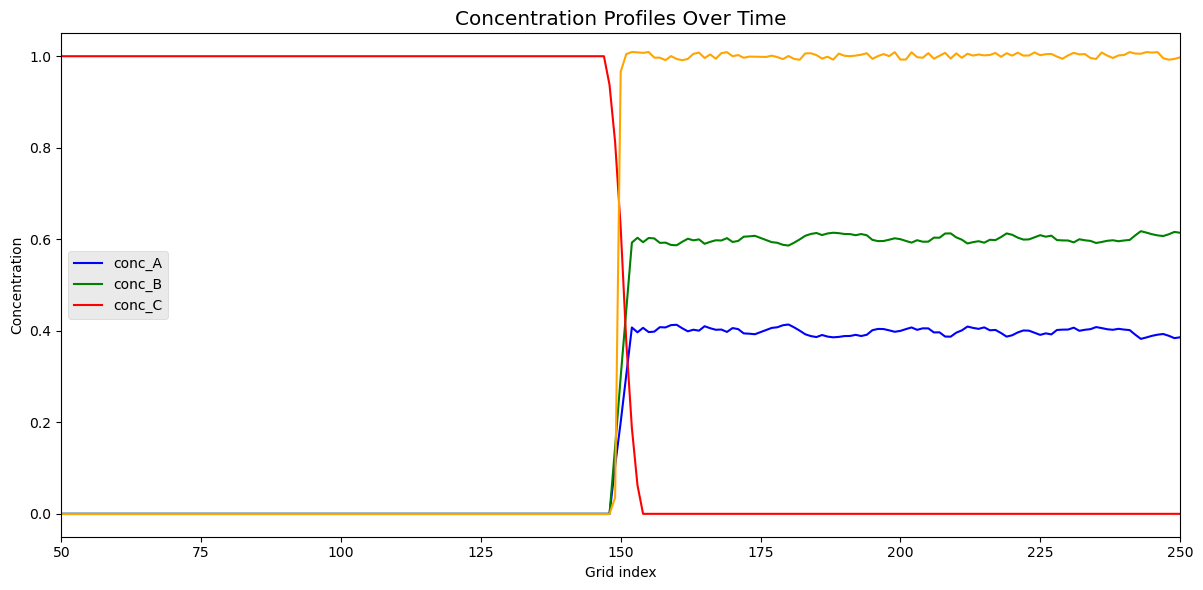

In [7]:
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
# Smooth function for 1D arrays
def smooth(arr, window=3):
    return np.convolve(arr, np.ones(window)/window, mode='same')

# Setup for animation
window_size = 4  # smoothing window
n_frames = len(conc_A)
x_vals = np.arange(conc_A[0].shape[0])  # assuming 1D plot along axis

fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use('ggplot')

line_a, = ax.plot([], [], label='conc_A', color='blue')
line_b, = ax.plot([], [], label='conc_B', color='green')
line_c, = ax.plot([], [], label='conc_C', color='red')
# line_d = ax.axvline(x=0, color='purple', linestyle='--', label='Interface Position')

# vline1 = ax.axvline(x=n_liquid_rows, color='black', linestyle='--', label='Interface')

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('Grid index')
ax.set_ylabel('Concentration')
ax.set_title('Concentration Profiles Over Time')
ax.legend(loc='center left')
line_phi, = ax.plot([], [], label='phi', color='orange')
plt.tight_layout()
plt.xlim(50,250)
# Animation update function
def update(frame):
    smoothed_cA = smooth(conc_A[frame], window=window_size)
    smoothed_cB = smooth(conc_B[frame], window=window_size)
    cC = 1 - smoothed_cA - smoothed_cB
    smoothed_cC = smooth(np.clip(cC, 1e-6, 1.0), window=window_size)
    line_a.set_data(x_vals, smoothed_cA)
    line_b.set_data(x_vals, smoothed_cB)
    line_c.set_data(x_vals, smoothed_cC)
    line_phi.set_data(x_vals, phi_values[frame])
      # Update the x-coordinate of the vertical line
    return line_a, line_b, line_c,line_phi

# Create animation
ani = FuncAnimation(fig, update, frames=n_frames, blit=True, interval=50)

 ## **Uncomment and execute the cell below to generate the animation**

In [ ]:
# from IPython.display import HTML
# from matplotlib import rc
# rc('animation', embed_limit=100)
# HTML(ani.to_jshtml())
# ani.save('phasefield_concentration_evolution.gif', writer='pillow', fps=20, dpi=150)